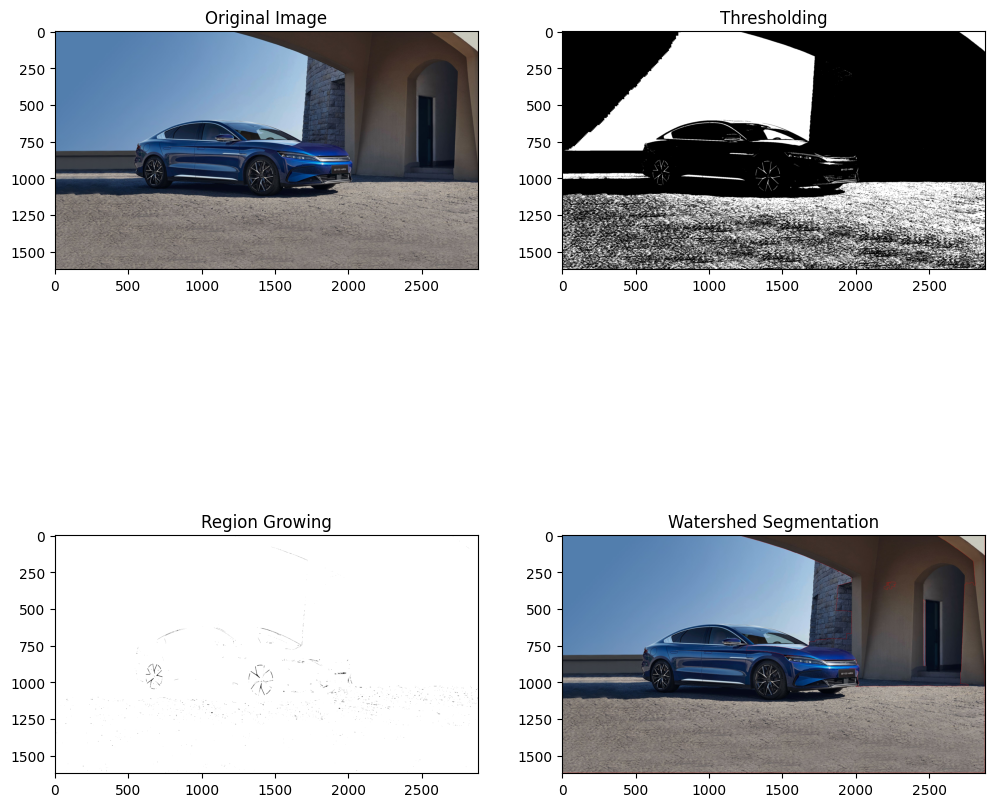

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a sample image
image = cv2.imread('test_img.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to segment the image
ret, thresholded = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

# Apply region growing segmentation
def region_growing(image, seed):
    visited = np.zeros_like(image)
    stack = [seed]
    while stack:
        x, y = stack.pop()
        if visited[x, y] == 1:
            continue
        visited[x, y] = 1
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1]:
                    if abs(int(image[nx, ny]) - int(image[x, y])) < 30:
                        stack.append((nx, ny))
    return visited

seed_point = (100, 100)  # You can choose your own seed point
region_grown = region_growing(gray_image, seed_point)

# Apply watershed segmentation
def watershed_segmentation(image):
    # Convert to grayscale and apply thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labeling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all the labels so that sure background is not 0 but 1
    markers = markers + 1

    # Mark the region of unknown with 0
    markers[unknown == 255] = 0

    # Apply the watershed algorithm
    cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]

    return image

watershed_result = watershed_segmentation(image.copy())

# Display the original and segmented images
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(thresholded, cmap='gray')
plt.title('Thresholding')

plt.subplot(2, 2, 3)
plt.imshow(region_grown, cmap='gray')
plt.title('Region Growing')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(watershed_result, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')

plt.show()
